In [2]:
#Libraries for math and data manipulation
import numpy as np
import pandas as pd
import math
import numpy.random as rand
import scipy as sp
import sys
from datetime import datetime

#Plotting stuff
import matplotlib.pyplot as plt
import seaborn
import corner
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True) #Want to be able to use tex in the plot labels
seaborn.set_style('ticks')
seaborn.set_color_codes()

#Machine learning stuff
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier   #This is a single decision tree
from sklearn.ensemble import ExtraTreesClassifier #Random forest of trees
import graphviz                                   #This package lets you visualize the tree
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

### Data Exploration

What features explain most of the variance in the datraset? Which are good predictors? What method should we use? I played around with a bunch of different stuff in this notebook. This was all done when we were still focusing on the actual diagnosis as the predicted feature.

In [3]:
#Read in stata datafile, and convert it to a cvs.
#data_stata = pd.io.stata.read_stata('../ProjectDef/cnsfinall2.dta')
#Convert to .csv. Now you never need to do this again
#data_stata.to_csv('../Data/cns_data.csv')

In [4]:
data_raw = pd.read_csv("../Data/cns_data.csv")   #Using Pandas for data manipulation

In [5]:
#Delete useless columns (like surename, initials, etc.)
data_df = data_raw.drop(['surnamenam','patinit','patientreg','mothinit'],axis=1)

Here are the actual diagnoses:

In [6]:
data_df.diag.unique()

array(['malaria', '0.0', 'cereb malaria', 'virus-bacteria', 'bacteremia',
       'bact meningitis', 'virus-other', 'virus-malaria',
       'malaria-bacterial', 'tb', 'virus', 'crypto'], dtype=object)

Seasonality may be of importance, so map to month and day from full date to be able to capture that:

In [7]:
#Adding a variable that is just 'month and day' - seems better to capture seasonality.
data_df['month'] = pd.DatetimeIndex(data_df['incdate']).month
data_df['day'] = pd.DatetimeIndex(data_df['incdate']).day
data_df['monthday'] = data_df['month']*30+data_df['day']

By looking at the variable definitions in the project definition folder, I selected a set that would be available at intake or very cheaply/easily thereafter:

In [8]:
#Select input features:
clin_df = data_df.loc[:,['glasgtot','blanttot','clinjaund','clinhepato','clinspleno','clinconv','clindehyd',\
                          'clinoedem','clinlymph','clinresp','clinablung','clincyan','clincapref','clincoldext',\
                         'clinearinf','clinanemia','clinorcand','clinhemmor','clinaids',\
                         'abdpain','vom','diar','head','muscle','conv',\
                         'sex','ageyrs','agemth','incdate',\
                         'temp','card','resp','sbp','dbp','weight','height','muac',\
                          'mhhosp', 'mhdevsp', 'mhsickle', 'mhchronstat',\
                         'monthday','dimain', \
                         'incirrit', 'inchead', 'incphoto',\
                         'incfont', 'incneuro' , 'incseiza', 'incseizh','incpurp',\
                         'malaria', #is malaria confirmed? I'm assuming this is the rapid diagnostic but idk
                          'diag']] #This is the final diagnosis - will be the 'label'

All of these yes/no and other categorical variables need to be mapped to numbers for actual data manipulation.

In [9]:
#Convert the date into a useful value. This just counts the days from the beginning of the dataset 
clin_df['incdate'] = pd.to_datetime(clin_df['incdate'])
clin_df['date'] = (clin_df['incdate'] - clin_df['incdate'].min())  / np.timedelta64(1,'D')

#Mapping yes/no to 1/0
clin_df['clinjaund'] = clin_df.clinjaund.map({'Yes': 1, 'No': 0})
clin_df['clinhepato'] = clin_df.clinhepato.map({'Yes': 1, 'No': 0})
clin_df['clinspleno'] = clin_df.clinspleno.map({'Yes': 1, 'No': 0})
clin_df['clinconv'] = clin_df.clinconv.map({'Yes': 1, 'No': 0})
clin_df['clindehyd'] = clin_df.clindehyd.map({'Yes': 1, 'No': 0})
clin_df['clinoedem'] = clin_df.clinoedem.map({'Yes': 1, 'No': 0})
clin_df['clinlymph'] = clin_df.clinlymph.map({'Yes': 1, 'No': 0})
clin_df['clinresp'] = clin_df.clinresp.map({'Yes': 1, 'No': 0})
clin_df['clinablung'] = clin_df.clinablung.map({'Yes': 1, 'No': 0})
clin_df['clincyan'] = clin_df.clincyan.map({'Yes': 1, 'No': 0})
clin_df['clincapref'] = clin_df.clincapref.map({'Yes': 1, 'No': 0})
clin_df['clincoldext'] = clin_df.clincoldext.map({'Yes': 1, 'No': 0})
#clin_df['clinearinf'] = clin_df.clinearinf.map({'Yes': 1, 'No': 0})
#clin_df['clintonsil'] = clin_df.clintonsil.map({'Yes': 1, 'No': 0})
clin_df['clinorcand'] = clin_df.clinorcand.map({'Yes': 1, 'No': 0})
clin_df['clinhemmor'] = clin_df.clinhemmor.map({'Yes': 1, 'No': 0})
clin_df['clinaids'] = clin_df.clinaids.map({'Yes': 1, 'No': 0})
clin_df['vom'] = clin_df.vom.map({'Yes': 1, 'No': 0})
clin_df['diar'] = clin_df.diar.map({'Yes': 1, 'No': 0})
clin_df['headache'] = clin_df['head'] #Since 'head' is a function
clin_df['conv'] = clin_df.conv.map({'Yes': 1, 'No': 0})
clin_df['ageym'] = clin_df.ageyrs.astype(float)*12.
clin_df.agemth = clin_df.agemth.astype(float)
clin_df['age'] = clin_df.ageym + clin_df.agemth #total age in months


#Medical history variables
clin_df['mhhosp'] = clin_df.mhhosp.map({'Yes': 1, 'No':0})


#some slightly more compliated mappings
clin_df['abdpain'] = clin_df.abdpain.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})
clin_df['headache'] = clin_df.headache.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['muscle'] = clin_df.muscle.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':np.nan})

clin_df['dimain'] = clin_df.dimain.map({"Cerebral Malaria":0, "Meningoencephalitis":1, "Meningitis":2.,\
                                       "Other":3})

clin_df['mhdevsp'] = clin_df.mhdevsp.map({'OTHER':1, 'GLOBAL DEVELOPMENTAL DELAY':1, 'HYDROCEPHALUS':1,
       'HEARING LOSSES':1, 'MOTOR DEVELOPEMENTAL DELAY':1,
       'SPEECH DEVELOPEMENTAL DELAY':1})

#Mapping of inclusion variables 6-8 MLW
clin_df['incirrit'] = clin_df.incirrit.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['inchead'] = clin_df.inchead.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incphoto'] = clin_df.incphoto.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incfont'] = clin_df.incfont.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incneuro'] = clin_df.incneuro.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseiza'] = clin_df.incseiza.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incseizh'] = clin_df.incseizh.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})
clin_df['incpurp'] = clin_df.incpurp.map({"Don't know":0, 'No':0, 'Yes':1, 'Not applicable':0})

#Malaria diagnositc
clin_df['malaria'] = clin_df.malaria.map({'confirmed':2,'probable':1,'no':0})


#This coding is going to be important. You'll want to figure out which categories are useful, and which
#are practical.
clin_df['diag'] = clin_df.diag.map({'malaria':0, 'cereb malaria':0,'virus-malaria':0,\
                                    'virus-bacteria':1, 'bacteremia':1,'bact meningitis':1,\
                                    'virus-other':2,'virus':2,'malaria-bacterial':2,\
                                    'tb':2,'crypto':2, '0.0':3})

A lot of these have very few actual answers. i.e., 'headache.' What happens if you map 'nan' to 'No'? 

This isn't something we've explored the consequences of - could be something to look into.

In [10]:

values = {'clinjaund':0,'clinhepato':0,'clinaids':0,'clinhemmor':0,'clinorcand':0,\
          'clinresp':0,'clinlymph':0,'clindehyd':0,'clinoedem':0,'clinablung':0,'clincyan':0,'clincapref':0,
          'clincoldext':0, 'mhchronstat':0, 'mhdevsp':0,\
         'conv':0,'abdpain':0,'vom':0,'diar':0,'headache':0,'muscle':0}
clin_df = clin_df.fillna(value=values)

In [11]:
#For the more complicated variables, i.e. those with more than two responses, you don't actually want to treat
#them as a continuous variable. You need to map them to a series of yes/no questions.
clin_df['CMalaria'] = clin_df.dimain.map({0:1,1:0,2:0,3:0})
clin_df['Enceph'] = clin_df.dimain.map({0:0,1:1,2:0,3:0})
clin_df['Mening'] = clin_df.dimain.map({0:0,1:0,2:1,3:0})
clin_df['Other'] = clin_df.dimain.map({0:0,1:0,2:0,3:1})

print(clin_df.dimain.unique())

[0. 1. 2. 3.]


In [12]:
#Pick the features to classify with.
Xlabels = ['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clinhepato','clinaids','clinhemmor','clinorcand',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                      'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh',\
                      'incpurp','malaria'] #This is just for plotting.
X_pd = clin_df.loc[:,['CMalaria','Enceph','Mening','Other',\
                      'headache','age','temp','date',\
                      'clinjaund','clinhepato','clinaids','clinhemmor','clinorcand',\
                      'clinresp','clinlymph','clindehyd','clinoedem','clinablung','clincyan','clincapref',\
                      'glasgtot', 'dbp', 'sbp','resp','card','weight','height','muac',\
                      'mhhosp','mhchronstat', 'mhdevsp',\
                      'conv','abdpain','vom','diar','muscle','monthday',\
                       'incirrit', 'inchead', 'incphoto',\
                      'incfont', 'incneuro' , 'incseiza', 'incseizh','incpurp',\
                      'malaria',
                      'diag']]
X_pd = X_pd.dropna()  #Drop cases that have nan for *any* entry

In [13]:
#Get things into the correct format for scikit-learn. I've tried to use the convention throughout that variables
#ending in 'pd' are pandas dataframes.
Input = X_pd.as_matrix()        #creates a numpy array
Features = Input[:,0:-1].copy() #separate the features and labels
Labels = Input[:,-1].copy()
ncase = len(Input[:,0])
print(ncase)                     #checking that there are a reasonable number of cases left

361


/Users/laurasampson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
X = Features.copy()  #changing to X and y. For no real reason
y = Labels.copy()

In [15]:
#skl will split the data into training and test for you. Right now, I'm training on 2/3 of the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=True)
print(np.shape(X))

(361, 46)


In [16]:
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to tune.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Feature ranking:
1. feature 45 (0.244796)
2. feature 0 (0.065656)
3. feature 2 (0.049853)
4. feature 20 (0.036376)
5. feature 36 (0.033764)
6. feature 22 (0.031699)
7. feature 5 (0.030750)
8. feature 27 (0.030103)
9. feature 7 (0.026647)
10. feature 6 (0.026394)


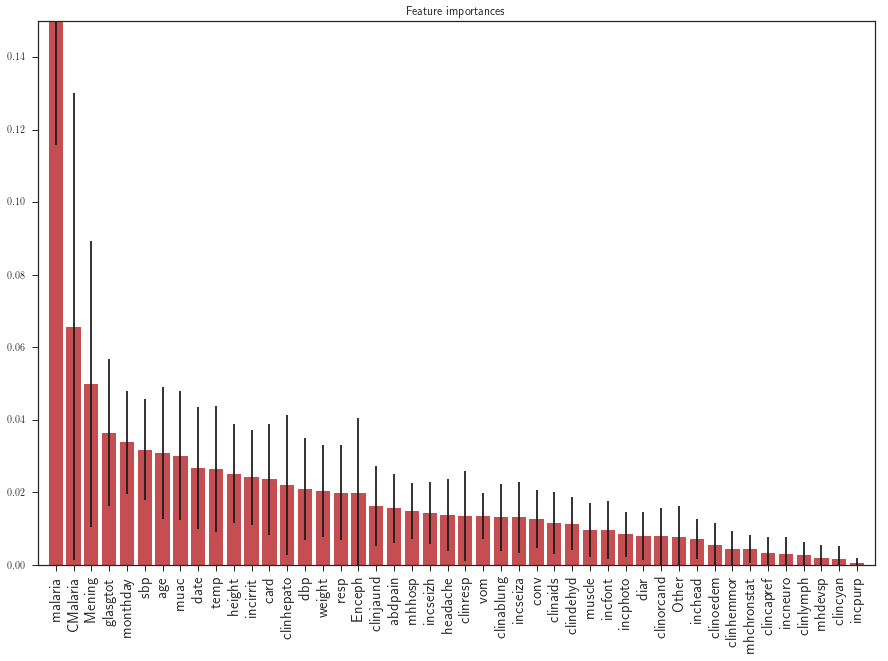

In [17]:
# Print the feature ranking
Xlabels = np.array(Xlabels)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [18]:
#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

In [32]:
#Print the confusion matrix - this is 'true classes' in the rows and 'sorted classes' in the columns. A perfect
#classifier would put all of the cases on the diagonal. Precision and recall are defined nicely here:
# https://en.wikipedia.org/wiki/Precision_and_recall.
print "Confusion matrix of random forest classifier, with ordering malaria, bacteria, virus, other."
print(confusion_matrix(y_test,y_pred))
print "Precision and recall for the four classes - malaria, bacteria, virus, other."
print "micro average is the normal average of the four class scores. macro average is the average accuracy over all \
patients - \
i.e. how many patients were correctly classified overall. Weighted average is the average of the four class scores, \
weighted by the number of patients who were truly in each class."
print(classification_report(y_test,y_pred))

Confusion matrix of random forest classifier, with ordering malaria, bacteria, virus, other.
[[57  0  2  2]
 [ 0  9  0 17]
 [ 3  0  0  8]
 [ 0  9  4 60]]
Precision and recall for the four classes - malaria, bacteria, virus, other.
micro average is the normal average of the four class scores. macro average is the average accuracy over all patients - i.e. how many patients were correctly classified overall. Weighted average is the average of the four class scores, weighted by the number of patients who were truly in each class.
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        61
         1.0       0.50      0.35      0.41        26
         2.0       0.00      0.00      0.00        11
         3.0       0.69      0.82      0.75        73

   micro avg       0.74      0.74      0.74       171
   macro avg       0.53      0.53      0.53       171
weighted avg       0.71      0.74      0.72       171



In [22]:
#Because this is a random forest, the output is actually a probability of being in each class. So this is looking
#at the maximum probability for each test case - it gives us a sense of how confident the classifier is in each
#
probmax = np.amax(y_pred_prob,axis=1)
edges = np.linspace(0,1,101)

histogram of the prediction probabilities for each case. Higher means the classifier was more certain.


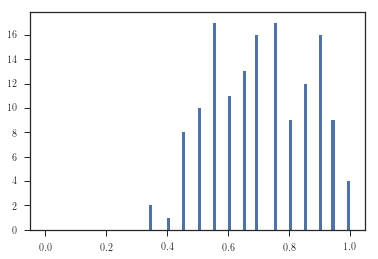

In [23]:
print "histogram of the prediction probabilities for each case. Higher means the classifier was more certain."
a,b,c = plt.hist(probmax,bins=edges)

In [24]:
#Feature selection - which were the most important?
Top20 = PlotLabels[:20] #Select the 20 most important labels.
TopPlus = np.append(Top20,['diag']) #'diag' needs to be included, because it's the outcome variable
print TopPlus

['malaria' 'CMalaria' 'Mening' 'glasgtot' 'monthday' 'sbp' 'age' 'muac'
 'date' 'temp' 'height' 'incirrit' 'card' 'clinhepato' 'dbp' 'weight'
 'resp' 'Enceph' 'clinjaund' 'abdpain' 'diag']


In [27]:
#Recursive Feature Extraction
#Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 10)
Data = clin_df[TopPlus]
Data = Data.dropna()
Data = Data.as_matrix()
X = Data[:,0:-1]
y = Data[:,-1]
print np.shape(X)

fit = rfe.fit(X, y)

print("Number of Features after recursive selection: %d") % fit.n_features_
print("Feature Ranking: %s") % fit.ranking_
TopFeatures = Top20[fit.support_].copy()
TopFeatures = np.append(TopFeatures,['diag'])
print TopFeatures

(361, 20)
Number of Features after recursive selection: 10
Feature Ranking: [ 1  1  1  1 10  7  4  3 11  1  5  1  6  1  8  2  9  1  1  1]
['malaria' 'CMalaria' 'Mening' 'glasgtot' 'temp' 'incirrit' 'clinhepato'
 'Enceph' 'clinjaund' 'abdpain' 'diag']


/Users/laurasampson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [28]:
#Select just these top features from the data:
TopData = clin_df[TopFeatures]
TopData = TopData.dropna()
TopData = TopData.as_matrix()

/Users/laurasampson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [29]:
#Go through the whole classification process again:

X = TopData[:,0:-1]
Y = TopData[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=True)
#Actual classifier. This is doing n_estimators trees, up to max_depth cuts. Something to play with.
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0,max_depth=50 )

#Fit the classifier.
forest.fit(X_train, y_train)

#extract the 'importances' of the features
importances = forest.feature_importances_
#calculate standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

#Make the predictions on the test data
y_pred_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

Feature ranking:
1. feature 0 (0.400128)
2. feature 4 (0.213564)
3. feature 3 (0.131154)
4. feature 1 (0.070949)
5. feature 6 (0.036493)
6. feature 5 (0.035256)
7. feature 2 (0.032259)
8. feature 9 (0.030731)
9. feature 7 (0.025102)
10. feature 8 (0.024364)


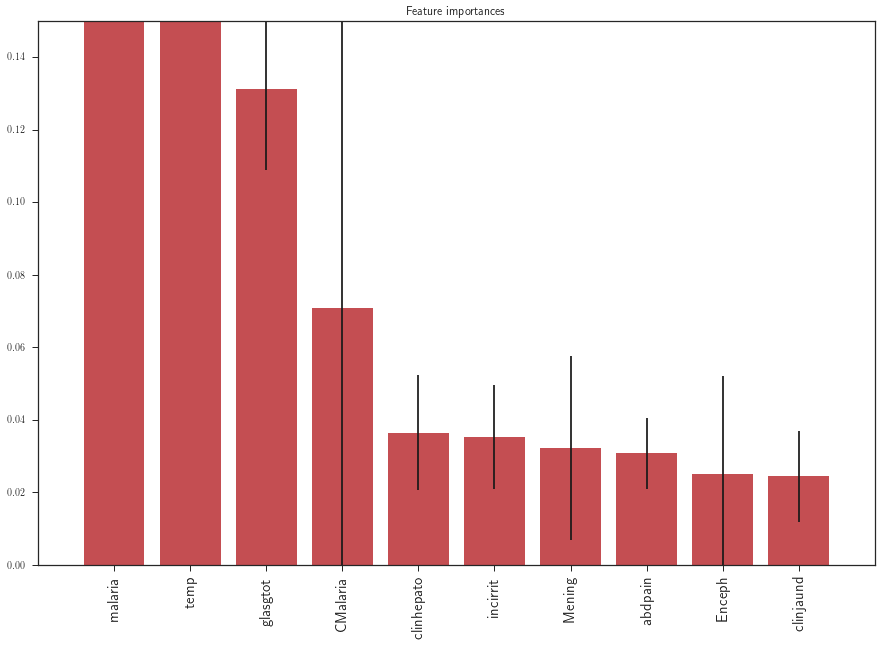

In [30]:
# Print the feature ranking
Xlabels = np.array(TopFeatures)
PlotLabels = Xlabels[indices]
print("Feature ranking:")
#for full feature listing use this as the range: X.shape[1]
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), PlotLabels, rotation='vertical',fontsize=15)
plt.xlim([-1, X.shape[1]])
plt.ylim(0,0.15)
plt.show()

In [33]:
#Print the confusion matrix again:
print("Confusion matrix for recursively selected feature model. Order: malaria, bacteria, virus, other.")
print(confusion_matrix(y_test,y_pred))
print("Classification report. Things did not change much from the previous model.")
print(classification_report(y_test,y_pred))

Confusion matrix for recursively selected feature model. Order: malaria, bacteria, virus, other.
[[57  0  2  2]
 [ 0  9  0 17]
 [ 3  0  0  8]
 [ 0  9  4 60]]
Classification report. Things did not change much from the previous model.
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94        61
         1.0       0.50      0.35      0.41        26
         2.0       0.00      0.00      0.00        11
         3.0       0.69      0.82      0.75        73

   micro avg       0.74      0.74      0.74       171
   macro avg       0.53      0.53      0.53       171
weighted avg       0.71      0.74      0.72       171



In [34]:
#I looked at PCA a little bit - the first principle component does explain the large majority of the variance, which
#is perhaps interesting. Didn't follow through much with this approach.

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
fit = pca.fit(X)
# summarize components
print("Explained Variance: %s") % fit.explained_variance_ratio_
print(fit.components_)

Explained Variance: [0.80410536 0.07540366 0.05748658]
[[ 0.09190689  0.05709271 -0.02820252 -0.99166493  0.01125928 -0.04859212
   0.03256549 -0.02072209  0.01003316 -0.00450292]
 [ 0.13293338  0.05763131 -0.01484452  0.0267388   0.98700996  0.03255908
   0.00572533 -0.04919187 -0.00655306  0.018103  ]
 [ 0.8615848   0.31712622 -0.28082521  0.1148901  -0.14508748 -0.05192527
   0.17711281 -0.07654247  0.05875075  0.02478097]]
